In [1]:
%matplotlib inline

In [2]:
import sqlite3
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import sys
sys.path.insert(0, os.path.abspath('..'))
from milleniumcohort import create_config
config = create_config('../config.yml')

In [4]:
conn = sqlite3.connect(os.path.join(config.model_path, 'milleniumcohort.db'))

In [5]:
state_times_long = pd.read_sql('Select filename, state, count(*) from data_with_states group by filename, state', conn)
state_times = state_times_long.pivot('filename', 'state')

In [6]:
cutoff_times_long = pd.read_sql('Select filename, heuristic, count(*) from data_with_states group by filename, heuristic', conn)
cutoff_times = cutoff_times_long.pivot('filename', 'heuristic')

In [7]:
state_cutoff_times_long = pd.read_sql('Select filename, heuristic, state, count(*) from data_with_states group by filename, heuristic, state', conn)

In [8]:
state_cutoff_times_long.head()

,filename,heuristic,state,count(*)
0,__016563_2015-10-27 09-40-29.bin_day1.csv,1,5,3110
1,__016563_2015-10-27 09-40-29.bin_day1.csv,1,6,3
2,__016563_2015-10-27 09-40-29.bin_day1.csv,1,7,13
3,__016563_2015-10-27 09-40-29.bin_day1.csv,2,0,178
4,__016563_2015-10-27 09-40-29.bin_day1.csv,2,1,8


In [9]:
state_cutoff_times_long['filename'].nunique()

912

In [10]:
state_cutoff_times = state_cutoff_times_long.pivot_table(values='count(*)', 
                                                         index='filename', 
                                                         columns=['heuristic', 'state'])
total_5sec = state_cutoff_times.sum(axis=1)
state_cutoff_times_norm = state_cutoff_times.divide(total_5sec, axis='index')

# Only take min 20 hours
state_cutoff_times_norm = state_cutoff_times_norm[total_5sec>20*60*12]
state_cutoff_times_norm = state_cutoff_times_norm.fillna(0)

In [11]:
total_5sec = state_times.sum(axis=1)
state_times_norm = state_times.divide(total_5sec, axis='index')

# Only take min 20 hours
state_times_norm = state_times_norm[total_5sec>20*60*12]
state_times_norm = state_times_norm.fillna(0)

In [12]:
total_5sec = cutoff_times.sum(axis=1)
cutoff_times_norm = cutoff_times.divide(total_5sec, axis='index')

# Only take min 20 hours
cutoff_times_norm = cutoff_times_norm[total_5sec>20*60*12]
cutoff_times_norm = cutoff_times_norm.fillna(0)

In [13]:
from sklearn.decomposition import PCA

(699, 10)


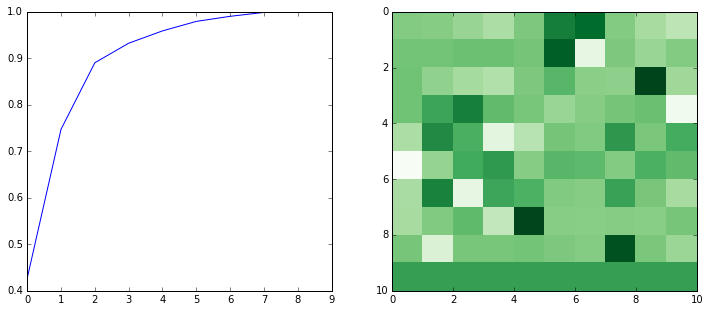

In [14]:
X_states = state_times_norm.as_matrix()
print(X_states.shape)
fig, axes = plt.subplots(1,2, figsize=(12,5))
pca = PCA(n_components=X_states.shape[1])
pca.fit(X_states)
axes[0].plot(np.cumsum(pca.explained_variance_ratio_))
axes[1].pcolor(pca.components_, cmap=plt.cm.Greens)
axes[1].invert_yaxis()

(699, 10)


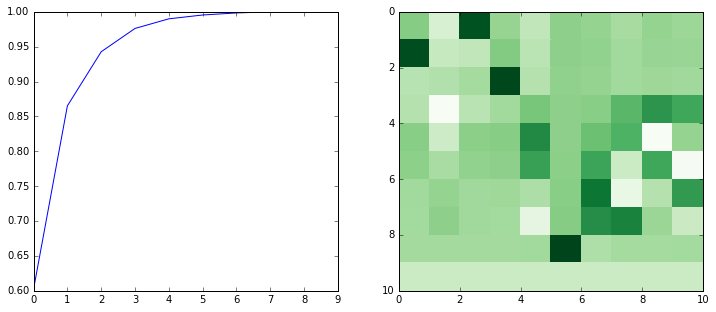

In [15]:
X_cutoff = cutoff_times_norm.as_matrix()
print(X_cutoff.shape)
fig, axes = plt.subplots(1,2, figsize=(12,5))
pca_cutoff = PCA(n_components=X_cutoff.shape[1])
pca_cutoff.fit(X_cutoff)
axes[0].plot(np.cumsum(pca_cutoff.explained_variance_ratio_), label='cut-off')
axes[1].pcolor(pca_cutoff.components_, cmap=plt.cm.Greens)
axes[1].invert_yaxis()

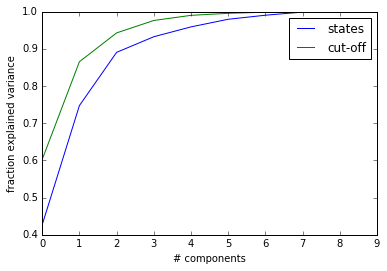

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='states')
plt.plot(np.cumsum(pca_cutoff.explained_variance_ratio_), label='cut-off')
plt.xlabel('# components')
plt.ylabel('fraction explained variance')
plt.legend()
plt.show()

In [17]:
cumvars = pd.DataFrame({'state': np.cumsum(pca.explained_variance_ratio_), 
              'cut-off': np.cumsum(pca_cutoff.explained_variance_ratio_)})
cumvars.index = np.arange(1, 11)
cumvars

,cut-off,state
1,0.602489,0.427021
2,0.865201,0.747319
3,0.942725,0.890441
4,0.976155,0.932423
5,0.989934,0.958923
6,0.995426,0.979353
7,0.998366,0.990285
8,0.999913,0.998683
9,1.000000,1.000000
10,1.000000,1.000000


In [18]:
def get_pcolorplot(correlations, ax, cmap='coolwarm', vmin=-1, vmax=1, xlabels=None, ylabels=None):
    ax.pcolor(correlations, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_yticks(np.arange(correlations.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(correlations.shape[1]) + 0.5, minor=False)
    if xlabels is None:
        xlabels = range(correlations.shape[0])
    if ylabels is None:
        ylabels2 = range(correlations.shape[1])
    else:
        ylabels2 = ylabels
    ax.invert_yaxis()
    ax.set_xticklabels(xlabels, minor=False)
    ax.set_yticklabels(ylabels2, minor=False)

# Center log ratio transformation

In [19]:
from scipy.stats import gmean
from skbio.stats.composition import ilr

In [64]:
def get_ilr(X):
    D = X.shape[1]
    X_out = np.zeros((X.shape[0], D-1))

    for j in range(1, D):
        c = np.sqrt(float(D-j)/(D-j+1))
        denom = np.power(X[:, j:].prod(axis=1), D-j)
        X_out[:, j-1] = c*np.log(X[:, j-1].transpose()/denom).transpose()
    return X_out

In [118]:
# take lognorm (compositional analysis)
eps = 0.000001
X_states[X_states==0] = eps
X_cutoff[X_cutoff==0] = eps

# CLR
X_lognorm_states_clr = np.log(X_states.transpose()/ gmean(X_states, axis=1)).transpose()
X_lognorm_cutoff_clr = np.log(X_cutoff.transpose()/ gmean(X_cutoff, axis=1)).transpose()

# ILR
X_lognorm_states_ilr = ilr(X_states)
X_lognorm_cutoff_ilr = ilr(X_cutoff)

#ILR, own implementation:
X_lognorm_states_ilr2 = get_ilr(X_states)
X_lognorm_cutoff_ilr2 = get_ilr(X_cutoff)

X_lognorm_states = X_lognorm_states_ilr
X_lognorm_cutoff = X_lognorm_cutoff_ilr

print(X_lognorm_states.shape, X_lognorm_cutoff.shape)

((699, 9), (699, 9))


In [119]:
print(np.sum(X_lognorm_cutoff==-np.infty))
print(np.sum(np.isnan(X_lognorm_cutoff)))
print(np.sum(X_lognorm_cutoff==np.infty))
print(np.sum(X_lognorm_states==-np.infty))
print(np.sum(np.isnan(X_lognorm_states)))
print(np.sum(X_lognorm_states==np.infty))

0
0
0
0
0
0


In [120]:
# fill infinity
#X_lognorm_states[X_lognorm_states==-np.infty] = -10000000
#X_lognorm_cutoff[X_lognorm_cutoff==-np.infty] = -10000000

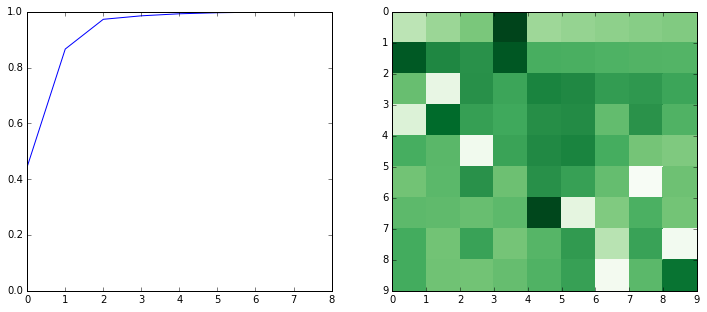

In [121]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
pca_state_log = PCA(n_components=X_lognorm_states.shape[1])
pca_state_log.fit(X_lognorm_states)
axes[0].plot(np.cumsum(pca_state_log.explained_variance_ratio_), label='log states')
axes[0].set_ylim(0,1)
axes[1].pcolor(pca_state_log.components_, cmap=plt.cm.Greens)
axes[1].invert_yaxis()

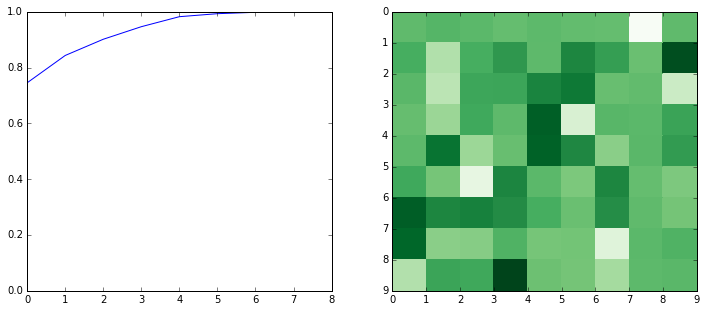

In [122]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
pca_cutoff_log = PCA(n_components=X_lognorm_cutoff.shape[1])
pca_cutoff_log.fit(X_lognorm_cutoff)
axes[0].plot(np.cumsum(pca_cutoff_log.explained_variance_ratio_), label='log cut-off')
axes[0].set_ylim(0,1)
axes[1].pcolor(pca_cutoff_log.components_, cmap=plt.cm.Greens)
axes[1].invert_yaxis()

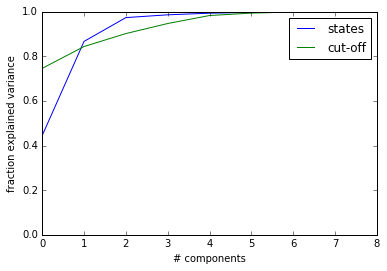

In [123]:
plt.plot(np.cumsum(pca_state_log.explained_variance_ratio_), label='states')
plt.plot(np.cumsum(pca_cutoff_log.explained_variance_ratio_), label='cut-off')
plt.xlabel('# components')
plt.ylabel('fraction explained variance')
plt.legend()
plt.ylim(0,1)
plt.show()

In [124]:
cumvars = pd.DataFrame({'state': np.cumsum(pca_state_log.explained_variance_ratio_), 
              'cut-off': np.cumsum(pca_cutoff_log.explained_variance_ratio_)})
cumvars.index = np.arange(1, len(cumvars)+1)
cumvars

,cut-off,state
1,0.745659,0.444742
2,0.843552,0.866521
3,0.901627,0.973143
4,0.946637,0.985616
5,0.982494,0.992913
6,0.993277,0.996674
7,0.998187,0.998454
8,0.999643,0.999800
9,1.000000,1.000000


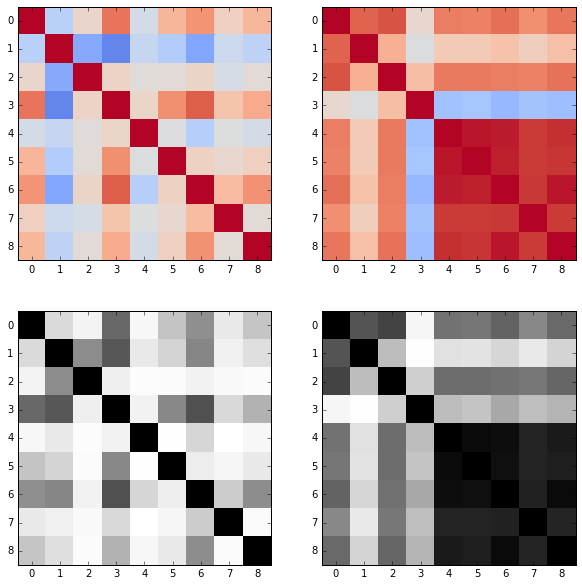

In [125]:
cor_states_log = np.corrcoef(X_lognorm_states.transpose())
cor_cutoff_log = np.corrcoef(X_lognorm_cutoff.transpose())

fig, axes = plt.subplots(2,2, figsize=(10,10))
get_pcolorplot(cor_cutoff_log, axes[0,0])
get_pcolorplot(cor_states_log, axes[0,1])
get_pcolorplot(np.abs(cor_cutoff_log), axes[1,0], plt.cm.Greys, 0, 1)
get_pcolorplot(np.abs(cor_states_log), axes[1,1], plt.cm.Greys, 0, 1)

In [117]:
cor_cutoff_log_values = cor_cutoff_log[~np.eye(cor_cutoff_log.shape[0], dtype=bool)]
cor_states_log_values = cor_states_log[~np.eye(cor_states_log.shape[0], dtype=bool)]

print('cutoff: {:.2f}±{:.2f}'.format(np.mean(np.abs(cor_cutoff_log_values)), np.std(np.abs(cor_cutoff_log_values))))
print('states: {:.2f}±{:.2f}'.format(np.mean(np.abs(cor_states_log_values)), np.std(np.abs(cor_states_log_values))))

cutoff: 0.38±0.27
states: 0.53±0.24


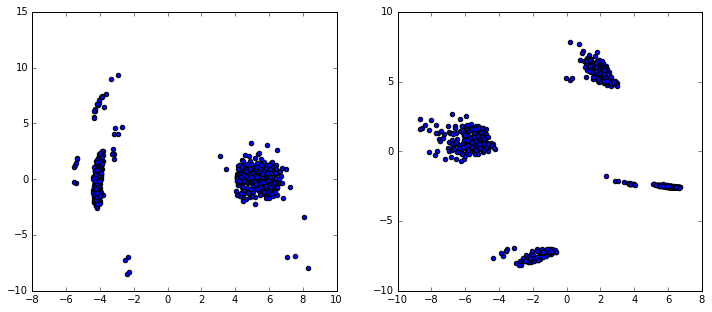

In [33]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

cutoff_transformed_log = pca_cutoff_log.transform(X_lognorm_cutoff)
axes[0].scatter(cutoff_transformed_log[:,0], cutoff_transformed_log[:,1])

states_transformed_log = pca_state_log.transform(X_lognorm_states)
axes[1].scatter(states_transformed_log[:,0], states_transformed_log[:,1])

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

axes[0].scatter(X_lognorm_cutoff[:,0], X_lognorm_cutoff[:,1])
axes[1].scatter(X_lognorm_states[:,0], X_lognorm_states[:,1])

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

axes[0].scatter(X_cutoff[:,0], X_cutoff[:,1])
axes[1].scatter(X_states[:,0], X_states[:,1])

In [ ]:
for i in range(10):
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    axes[0].scatter(X_cutoff[:,i], X_lognorm_cutoff[:,i])
    axes[1].scatter(X_states[:,i], X_lognorm_states[:,i])
    plt.show()

# Correlation

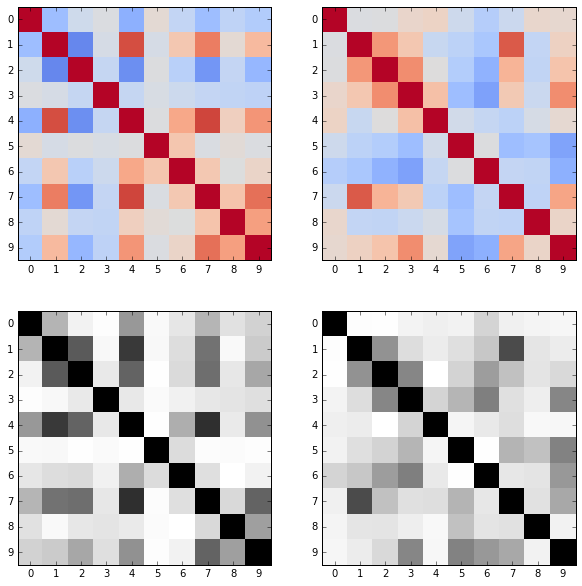

In [77]:
cor_states = np.corrcoef(X_states.transpose())
cor_cutoff = np.corrcoef(X_cutoff.transpose())
fig, axes = plt.subplots(2,2, figsize=(10,10))
get_pcolorplot(cor_cutoff, axes[0,0])
get_pcolorplot(cor_states, axes[0,1])
get_pcolorplot(np.abs(cor_cutoff), axes[1,0], plt.cm.Greys, 0, 1)
get_pcolorplot(np.abs(cor_states), axes[1,1], plt.cm.Greys, 0, 1)

In [78]:
# Get average absolute intercorrelation
dim = cor_cutoff.shape[0]
avgcor_cutoff = (np.abs(cor_cutoff).sum() - dim)/(dim*dim-dim)
dim = cor_states.shape[0]
avgcor_state = (np.abs(cor_states).sum() - dim)/(dim*dim-dim)
print(avgcor_cutoff, avgcor_state)

(0.27441128578840751, 0.25177732880029052)


In [79]:
cor_cutoff_values = cor_cutoff[~np.eye(cor_cutoff.shape[0], dtype=bool)]
cor_states_values = cor_states[~np.eye(cor_states.shape[0], dtype=bool)]

print('cutoff: {:.2f}±{:.2f}'.format(np.mean(np.abs(cor_cutoff_values)), np.std(np.abs(cor_cutoff_values))))
print('states: {:.2f}±{:.2f}'.format(np.mean(np.abs(cor_states_values)), np.std(np.abs(cor_states_values))))

cutoff: 0.27±0.24
states: 0.25±0.18


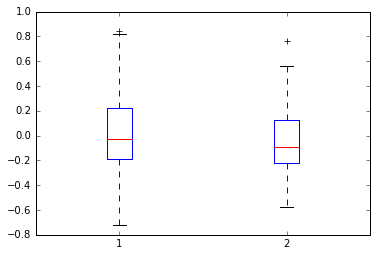

In [98]:
plt.boxplot((cor_cutoff_values, cor_states_values));

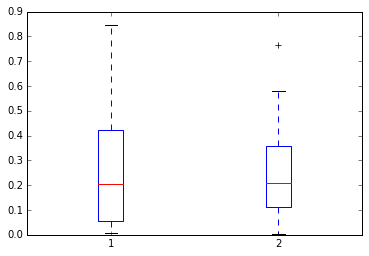

In [100]:
plt.boxplot((np.abs(cor_cutoff_values), np.abs(cor_states_values)));

In [108]:
print(sum(np.abs(cor_cutoff_values)>.5))
print(sum(np.abs(cor_states_values)>.5))

16
12


In [80]:
# Calculate t-test (this one is two-sided and we want one sided, so divide by 2)
import scipy
res = scipy.stats.ttest_ind(cor_cutoff_values, cor_states_values, equal_var=False)
print(res)
print('p-value: {:.3f}'.format(res.pvalue / 2))

Ttest_indResult(statistic=0.58227054112994392, pvalue=0.56113983975569215)
p-value: 0.281


In [81]:
heuristic_classes = [' 1 - sustained activity',  #1
                     ' 2 - non-bouted inactivity', #2
                     ' 3 - >=30min inactivity', #3 
                     ' 4 - 10-19min inactivity', #4
                     ' 5 - non-bouted LPA', #5
                     ' 6 - >=10min LPA', #6
                     ' 7 - 1-9min LPA', #7
                     ' 8 - non-bouted MVPA', #8
                     ' 9 - >=10min MVPA', #9
                    '10 - 1-9min MVPA' #10
                     ]
get_heuristic = lambda i: heuristic_classes[int(i)-1]

In [82]:
cutoff_times_norm.columns = heuristic_classes
state_times_norm.columns = np.arange(10)

In [83]:
cor = np.zeros((X_states.shape[1], X_cutoff.shape[1]))

for i in range(X_states.shape[1]):
    for j in range(X_cutoff.shape[1]):
        cor[i, j] = np.corrcoef(X_states[:,i], X_cutoff[:,j])[0,1]

In [84]:
cor_df = pd.DataFrame(cor)
cor_df.columns = heuristic_classes
cor_df

,1 - sustained activity,2 - non-bouted inactivity,3 - >=30min inactivity,4 - 10-19min inactivity,5 - non-bouted LPA,6 - >=10min LPA,7 - 1-9min LPA,8 - non-bouted MVPA,9 - >=10min MVPA,10 - 1-9min MVPA
0,-0.108543,0.276759,-0.187546,-0.135079,0.312582,0.048281,0.543753,0.058762,-0.029168,0.014748
1,-0.229365,0.217556,-0.333444,-0.126394,0.316616,-0.006202,-0.043460,0.554934,0.586035,0.685387
2,-0.288402,0.311191,-0.432104,-0.234663,0.502111,-0.016166,0.045060,0.684079,0.667329,0.809696
3,-0.410932,0.553726,-0.544500,-0.202829,0.848484,-0.019480,0.364302,0.829109,0.227948,0.545771
4,-0.110095,0.055579,-0.106268,-0.099954,0.277917,0.316210,0.669285,0.162977,0.006896,0.009190
5,0.987432,-0.395944,-0.108517,-0.025765,-0.487595,0.067559,-0.167604,-0.389196,-0.193810,-0.276880
6,0.017369,-0.632277,0.761114,0.195408,-0.700130,-0.088955,-0.319711,-0.614223,-0.267371,-0.491776
7,-0.408940,0.425748,-0.318797,0.018792,0.400478,-0.086078,-0.152073,0.590143,0.282444,0.480867
8,-0.353535,0.094554,0.229495,0.140122,-0.043104,0.020359,0.005129,-0.224911,-0.092394,-0.168644
9,-0.579183,0.806279,-0.466974,-0.044402,0.792879,-0.054055,0.182917,0.566970,0.039197,0.246530


In [85]:
cor_df.index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [86]:
state_order = [5, 6, 8, 9, 0, 7, 4, 3, 2, 1]
cor_df = cor_df.loc[state_order, :]
cor_ordered = cor_df.as_matrix()
cor_df

,1 - sustained activity,2 - non-bouted inactivity,3 - >=30min inactivity,4 - 10-19min inactivity,5 - non-bouted LPA,6 - >=10min LPA,7 - 1-9min LPA,8 - non-bouted MVPA,9 - >=10min MVPA,10 - 1-9min MVPA
5,0.987432,-0.395944,-0.108517,-0.025765,-0.487595,0.067559,-0.167604,-0.389196,-0.193810,-0.276880
6,0.017369,-0.632277,0.761114,0.195408,-0.700130,-0.088955,-0.319711,-0.614223,-0.267371,-0.491776
8,-0.353535,0.094554,0.229495,0.140122,-0.043104,0.020359,0.005129,-0.224911,-0.092394,-0.168644
9,-0.579183,0.806279,-0.466974,-0.044402,0.792879,-0.054055,0.182917,0.566970,0.039197,0.246530
0,-0.108543,0.276759,-0.187546,-0.135079,0.312582,0.048281,0.543753,0.058762,-0.029168,0.014748
7,-0.408940,0.425748,-0.318797,0.018792,0.400478,-0.086078,-0.152073,0.590143,0.282444,0.480867
4,-0.110095,0.055579,-0.106268,-0.099954,0.277917,0.316210,0.669285,0.162977,0.006896,0.009190
3,-0.410932,0.553726,-0.544500,-0.202829,0.848484,-0.019480,0.364302,0.829109,0.227948,0.545771
2,-0.288402,0.311191,-0.432104,-0.234663,0.502111,-0.016166,0.045060,0.684079,0.667329,0.809696
1,-0.229365,0.217556,-0.333444,-0.126394,0.316616,-0.006202,-0.043460,0.554934,0.586035,0.685387


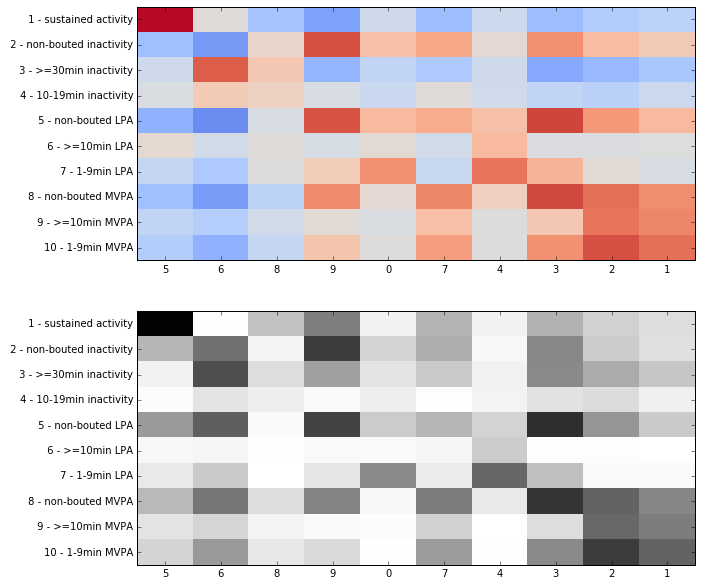

In [87]:
fig, axes = plt.subplots(2,1, figsize=(10,10))
get_pcolorplot(cor_ordered.transpose(), axes[0], xlabels=cor_df.index, ylabels=cor_df.columns)
get_pcolorplot(np.abs(cor_ordered.transpose()), axes[1], plt.cm.Greys, 0, 1, xlabels=cor_df.index, ylabels=cor_df.columns)

In [88]:
cor_series = cor_df.unstack()
cor_series.sort_values(ascending=False)

 1 - sustained activity     5    0.987432
 5 - non-bouted LPA         3    0.848484
 8 - non-bouted MVPA        3    0.829109
10 - 1-9min MVPA            2    0.809696
 2 - non-bouted inactivity  9    0.806279
 5 - non-bouted LPA         9    0.792879
 3 - >=30min inactivity     6    0.761114
10 - 1-9min MVPA            1    0.685387
 8 - non-bouted MVPA        2    0.684079
 7 - 1-9min LPA             4    0.669285
 9 - >=10min MVPA           2    0.667329
 8 - non-bouted MVPA        7    0.590143
 9 - >=10min MVPA           1    0.586035
 8 - non-bouted MVPA        9    0.566970
                            1    0.554934
 2 - non-bouted inactivity  3    0.553726
10 - 1-9min MVPA            3    0.545771
 7 - 1-9min LPA             0    0.543753
 5 - non-bouted LPA         2    0.502111
10 - 1-9min MVPA            7    0.480867
 2 - non-bouted inactivity  7    0.425748
 5 - non-bouted LPA         7    0.400478
 7 - 1-9min LPA             3    0.364302
 5 - non-bouted LPA         1    0

In [89]:
cutoff_times_norm.columns

Index([u' 1 - sustained activity', u' 2 - non-bouted inactivity',
       u' 3 - >=30min inactivity', u' 4 - 10-19min inactivity',
       u' 5 - non-bouted LPA', u' 6 - >=10min LPA', u' 7 - 1-9min LPA',
       u' 8 - non-bouted MVPA', u' 9 - >=10min MVPA', u'10 - 1-9min MVPA'],
      dtype='object')

 Now join states and categories based on the acceleration value

In [90]:
import re
group_names = ['sustained', 'inactivity', 'LPA', 'MVPA']
cutoff_groups = {n: [c for c in heuristic_classes if re.findall(n, c)] for n in group_names}
cutoff_groups

{'LPA': [' 5 - non-bouted LPA', ' 6 - >=10min LPA', ' 7 - 1-9min LPA'],
 'MVPA': [' 8 - non-bouted MVPA', ' 9 - >=10min MVPA', '10 - 1-9min MVPA'],
 'inactivity': [' 2 - non-bouted inactivity',
  ' 3 - >=30min inactivity',
  ' 4 - 10-19min inactivity'],
 'sustained': [' 1 - sustained activity']}

In [91]:
cutoff_grouped = pd.DataFrame({k: cutoff_times_norm[cutoff_groups[k]].sum(axis=1) for k in group_names})
cutoff_grouped = cutoff_grouped[group_names]

In [92]:
#state_groups = {'sustained':[2,9], 'inactivity': [0,3,4,6], 'LPA': [5, 1, 7], 'MVPA': [8]}
state_groups = {'sustained':[5], 'inactivity': [6, 8], 'LPA': [9, 0, 7, 4], 'MVPA': [3, 2, 1]}
state_grouped = pd.DataFrame({k: state_times_norm[state_groups[k]].sum(axis=1) for k in group_names})
state_grouped = state_grouped[group_names]

,c: sustained,c: inactivity,c: LPA,c: MVPA
s: sustained,0.987432,-0.466972,-0.467228,-0.357108
s: inactivity,-0.200373,0.924710,-0.660159,-0.643420
s: LPA,-0.596130,-0.162576,0.871432,0.421310
s: MVPA,-0.408362,-0.560576,0.716864,0.953346


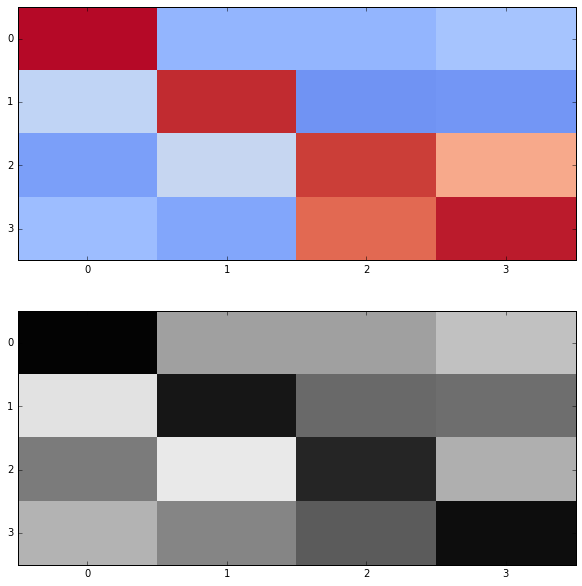

In [93]:
X_states_grouped = state_grouped.as_matrix()
X_cutoff_grouped = cutoff_grouped.as_matrix()
cor = np.zeros((X_states_grouped.shape[1], X_cutoff_grouped.shape[1]))

for i in range(X_states_grouped.shape[1]):
    for j in range(X_cutoff_grouped.shape[1]):
        cor[i, j] = np.corrcoef(X_states_grouped[:,i], X_cutoff_grouped[:,j])[0,1]
        
cor_df = pd.DataFrame(cor)
cor_df.columns = ['c: '+ x for x in cutoff_grouped.columns]
cor_df.index = ['s: '+ x for x in state_grouped.columns]

fig, axes = plt.subplots(2,1, figsize=(10,10))
get_pcolorplot(cor, axes[0])
get_pcolorplot(np.abs(cor), axes[1], plt.cm.Greys, 0, 1)
cor_df